In [1]:
import torch
import os
import pandas as pd
import numpy as np
from utils.config import config_dataset
from utils.helper import ObjectView
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from utils.utils_NFs import *
from models import *

# Set the torch seed for result reproducibility
torch_seed = 3307
torch.manual_seed(torch_seed)

In [2]:

indices = []
non_null_indexes = list(np.delete(np.asarray([i for i in range(96)]), indices))
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

X_train = torch.load("../data/london/tensor_small/y_tr.pt", weights_only=True)
X_test = torch.load("../data/london/tensor_small/y_val.pt", weights_only=True)
cond_train = torch.load("../data/london/tensor_small/X_tr.pt", weights_only=True)
cond_test = torch.load("../data/london/tensor_small/X_val.pt", weights_only=True)
print(X_train.shape)
print(X_test.shape)
print(cond_train.shape)
print(cond_test.shape)

X_train, X_val, cond_train, cond_val = train_test_split(X_train, cond_train, test_size=0.1, random_state=42)
X_train.shape, X_test.shape, cond_train.shape, cond_test.shape, X_val.shape, cond_val.shape

y_LS_scaler = StandardScaler()
y_LS_scaler.fit(X_train)
y_LS_scaled = y_LS_scaler.transform(X_train)
y_VS_scaled = y_LS_scaler.transform(X_val)
y_TEST_scaled = y_LS_scaler.transform(X_test)

x_LS_scaler = StandardScaler()
x_LS_scaler.fit(cond_train)
x_LS_scaled = x_LS_scaler.transform(cond_train)
x_VS_scaled = x_LS_scaler.transform(cond_val)
x_TEST_scaled = x_LS_scaler.transform(cond_test)

torch.Size([16696, 48])
torch.Size([4174, 48])
torch.Size([16696, 81])
torch.Size([4174, 81])


In [3]:
# n_s = 100
n_s = 20
N_q = 48

nb_epoch = 200
cf_UMNN_M = {
    'name': 'UMNN_M_1',
    'nb_steps': 1,
    'nb_layers': 4,
    'nb_neurons': 300,
    'out_size': 20,
    'weight_decay': 5e-4,
    'learning_rate': 1e-4,
    'conditioner_type': 'AutoregressiveConditioner',
    'normalizer_type': 'MonotonicNormalizer',
}

cf_AN_M = {
    'name': 'AN_M_1',
    'nb_steps': 5,
    'nb_layers': 5,
    'nb_neurons': 300,
    'out_size': 2,
    'weight_decay': 1e-3,
    'learning_rate': 1e-4,
    'conditioner_type': 'AutoregressiveConditioner',
    'normalizer_type': 'AffineNormalizer',
}
print('UMNN-M nb_steps %s nb_layers %s nb_neurons %s out_size %s weight_decay %.4e lr %.4e' % (cf_UMNN_M['nb_steps'], cf_UMNN_M['nb_layers'], cf_UMNN_M['nb_neurons'], cf_UMNN_M['out_size'], cf_UMNN_M['weight_decay'], cf_UMNN_M['learning_rate']))
print('AN-M   nb_steps %s nb_layers %s nb_neurons %s out_size %s weight_decay %.4e lr %.4e' % (cf_AN_M['nb_steps'], cf_AN_M['nb_layers'], cf_AN_M['nb_neurons'], cf_AN_M['out_size'], cf_AN_M['weight_decay'], cf_AN_M['learning_rate']))

UMNN-M nb_steps 1 nb_layers 4 nb_neurons 300 out_size 20 weight_decay 5.0000e-04 lr 1.0000e-04
AN-M   nb_steps 5 nb_layers 5 nb_neurons 300 out_size 2 weight_decay 1.0000e-03 lr 1.0000e-04


In [4]:
config = cf_UMNN_M # cf_UMNN_M
tag = "load"

if config['normalizer_type'] == 'AffineNormalizer':
    config['conditioner_args'] = {"in_size": y_LS_scaled.shape[1],
                                    "hidden": [config['nb_neurons']] * config['nb_layers'], "out_size": 2,
                                    "cond_in": x_LS_scaled.shape[1]}
    normalizer_type = AffineNormalizer
    config['normalizer_args'] = {}

elif config['normalizer_type'] == 'MonotonicNormalizer':
    config['conditioner_args'] = {"in_size": y_LS_scaled.shape[1],
                                    "hidden": [config['nb_neurons']] * config['nb_layers'],
                                    "out_size": config['out_size'], "cond_in": x_LS_scaled.shape[1]}
    normalizer_type = MonotonicNormalizer
    config['normalizer_args'] = {
        'integrand_net': [config['out_size'] * 2, config['out_size'] * 2, config['out_size'] * 2],
        'cond_size': config['out_size'], 'nb_steps': 50, 'solver': "CCParallel", 'hot_encoding': True}

config['Adam_args'] = {"lr": config['learning_rate'], "weight_decay": config['weight_decay']}

nfs = buildFCNormalizingFlow(nb_steps=config['nb_steps'], conditioner_type=AutoregressiveConditioner,
                                conditioner_args=config['conditioner_args'], normalizer_type=normalizer_type,
                                normalizer_args=config['normalizer_args'])
opt = torch.optim.Adam(nfs.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])

# --------------------------------------------------------------------------------------------------------------
# Fit the NFs
# --------------------------------------------------------------------------------------------------------------
print('Fit NFs with %s epochs' % (nb_epoch))
training_time = 0.
start = timer()
loss, best_flow, last_flow = fit_NF(nb_epoch=nb_epoch, x_LS=x_LS_scaled, y_LS=y_LS_scaled, x_VS=x_VS_scaled,
                                    y_VS=y_VS_scaled, x_TEST=x_TEST_scaled, y_TEST=y_TEST_scaled,
                                    flow=nfs,
                                    opt=opt, gpu=True)

end = timer()
training_time += end - start
print('Training time %.2f s' % (training_time))
epoch_min = np.nanargmin(loss[:, 1])
print('epoch %s ll VS is min = %.2f ll TEST = %.2f' % (epoch_min, loss[epoch_min, 1], loss[epoch_min, 2]))



Fit NFs with 200 epochs
2Epoch 100 Approximate time left : 1.131863 min - LS loss: 5.617720 VS loss: 7.437122 TEST loss: 8.089161Epoch 120 Approximate time left : 0.896786 min - LS loss: 5.309842 VS loss: 5.944578 TEST loss: 6.618122Epoch 140 Approximate time left : 0.666133 min - LS loss: 3.638724 VS loss: 4.681040 TEST loss: 5.411648Epoch 160 Approximate time left : 0.438676 min - LS loss: 5.408135 VS loss: 3.820392 TEST loss: 4.526774Epoch 180 Approximate time left : 0.213034 min - LS loss: 2.453334 VS loss: 3.446665 TEST loss: 4.244415Fitting time_tot 2 min
Training time 134.29 s
epoch 198 ll VS is min = 2.34 ll TEST = 3.11


In [ ]:
max_power = 1
# Scenarios are generated into a dict of length nb days (#VS or # TEST sizes)
# Each day of the dict is an array of shape (n_scenarios, 24)
generation_time = 0.
start = timer()
s_TEST = build_nfs_scenarios(n_s=n_s, x=x_TEST_scaled,
                                y_scaler=y_LS_scaler, flow=best_flow,
                                conditioner_args=config['conditioner_args'], max=max_power, gpu=True, tag=tag, non_null_indexes=non_null_indexes)
s_VS = build_nfs_scenarios(n_s=n_s, x=x_VS_scaled,
                            y_scaler=y_LS_scaler, flow=best_flow,
                            conditioner_args=config['conditioner_args'], max=max_power, gpu=True, tag=tag, non_null_indexes=non_null_indexes)


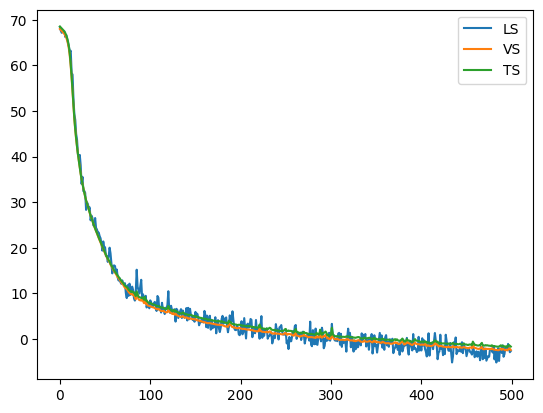

In [6]:
plt.figure()
plt.plot(loss[:, 0], label='LS')
plt.plot(loss[:, 1], label='VS')
plt.plot(loss[:, 2], label='TS')
plt.legend()

In [7]:
X_test_hat = s_TEST.reshape(-1, 48, s_TEST.shape[-1])
X_test_hat = torch.tensor(X_test_hat).permute(0, 2, 1)

In [8]:
torch.save(X_test_hat, "../result/data/london/load_hat_nf.pt")

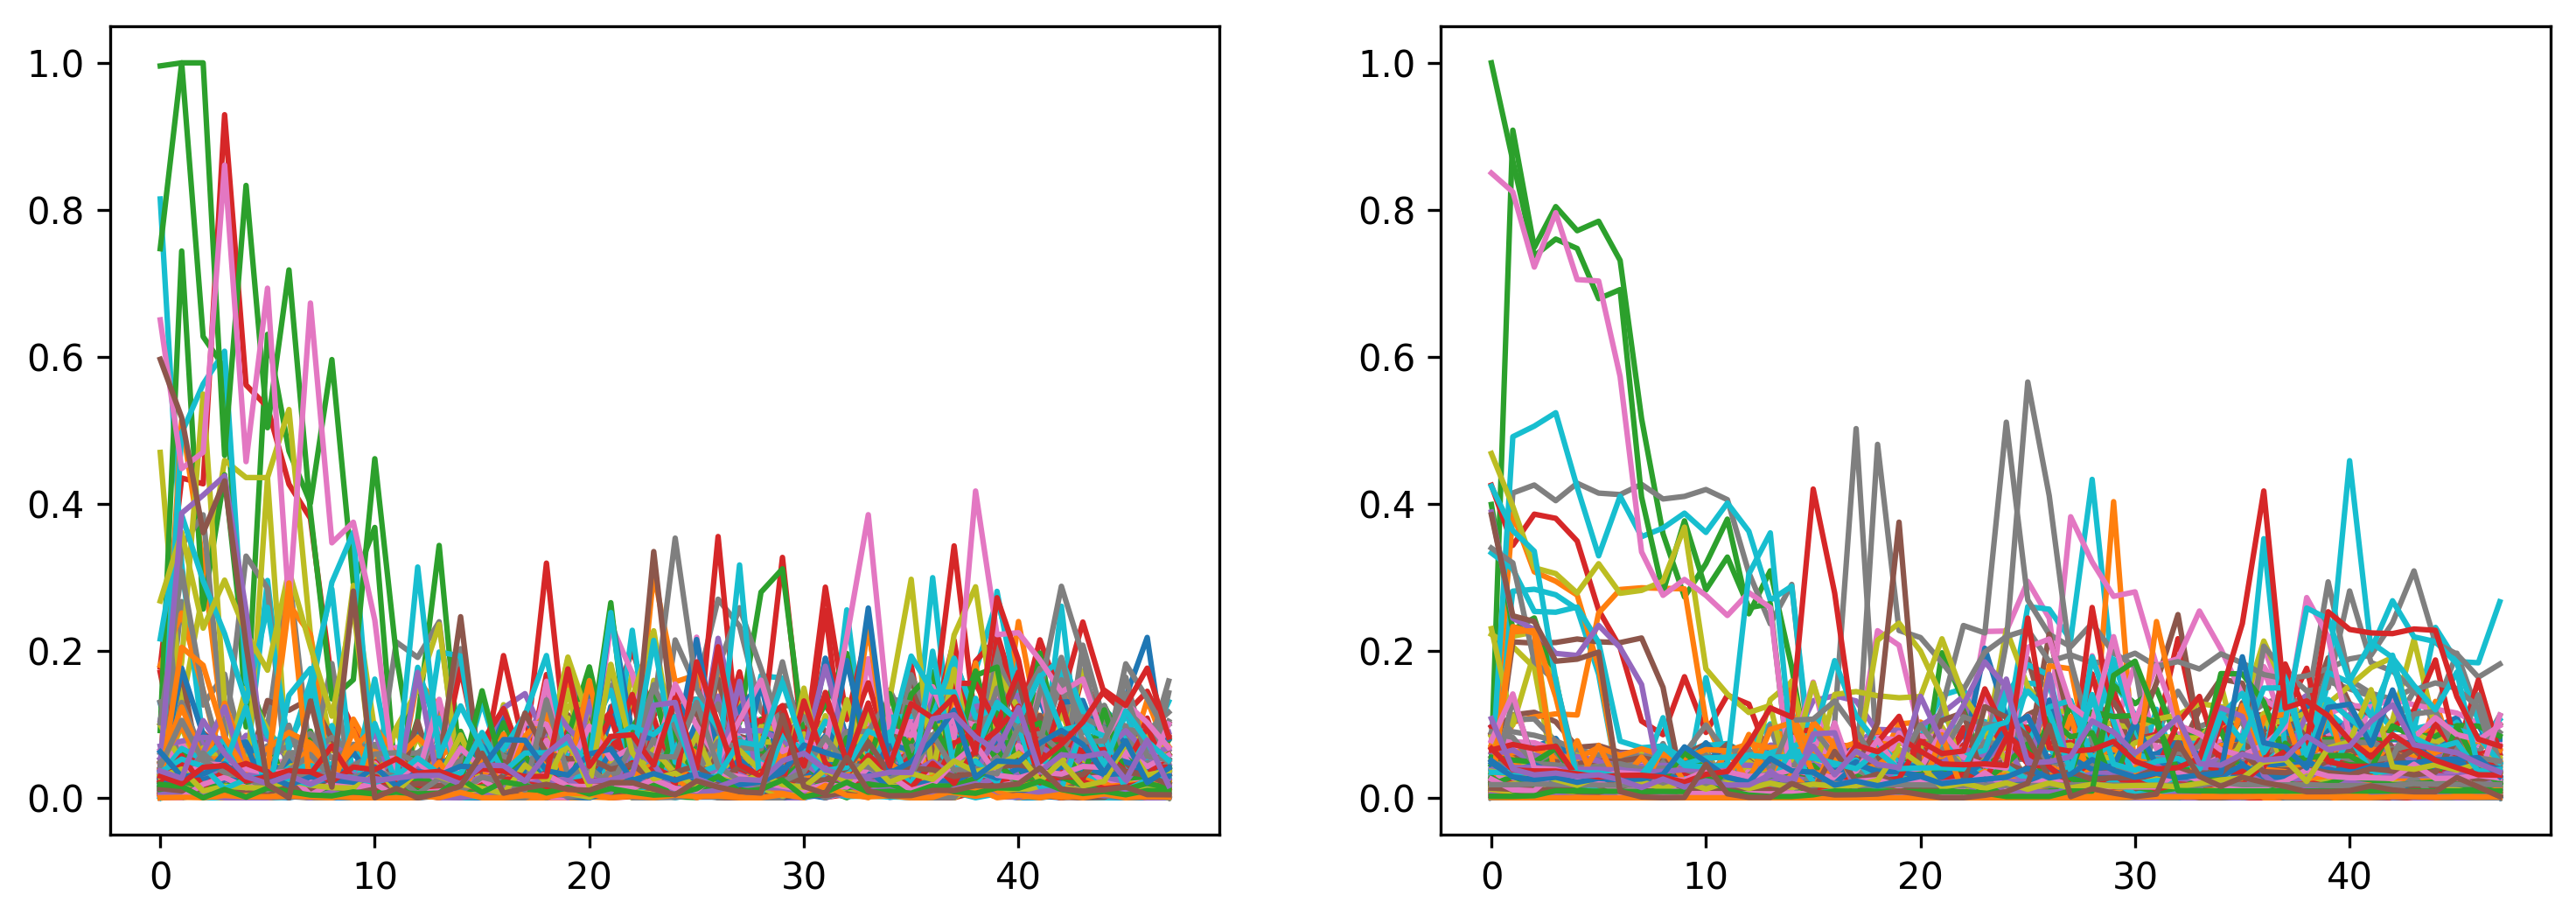

In [9]:
user = 0
plt.figure(figsize=(12,4), dpi=300)
plt.subplot(1,2,1)
for i in range(146*user, 146*(user+1)):
    plt.plot(X_test_hat[i, 0, :])
plt.subplot(1,2,2)
for i in range(146*user, 146*(user+1)):
    plt.plot(X_test[i])

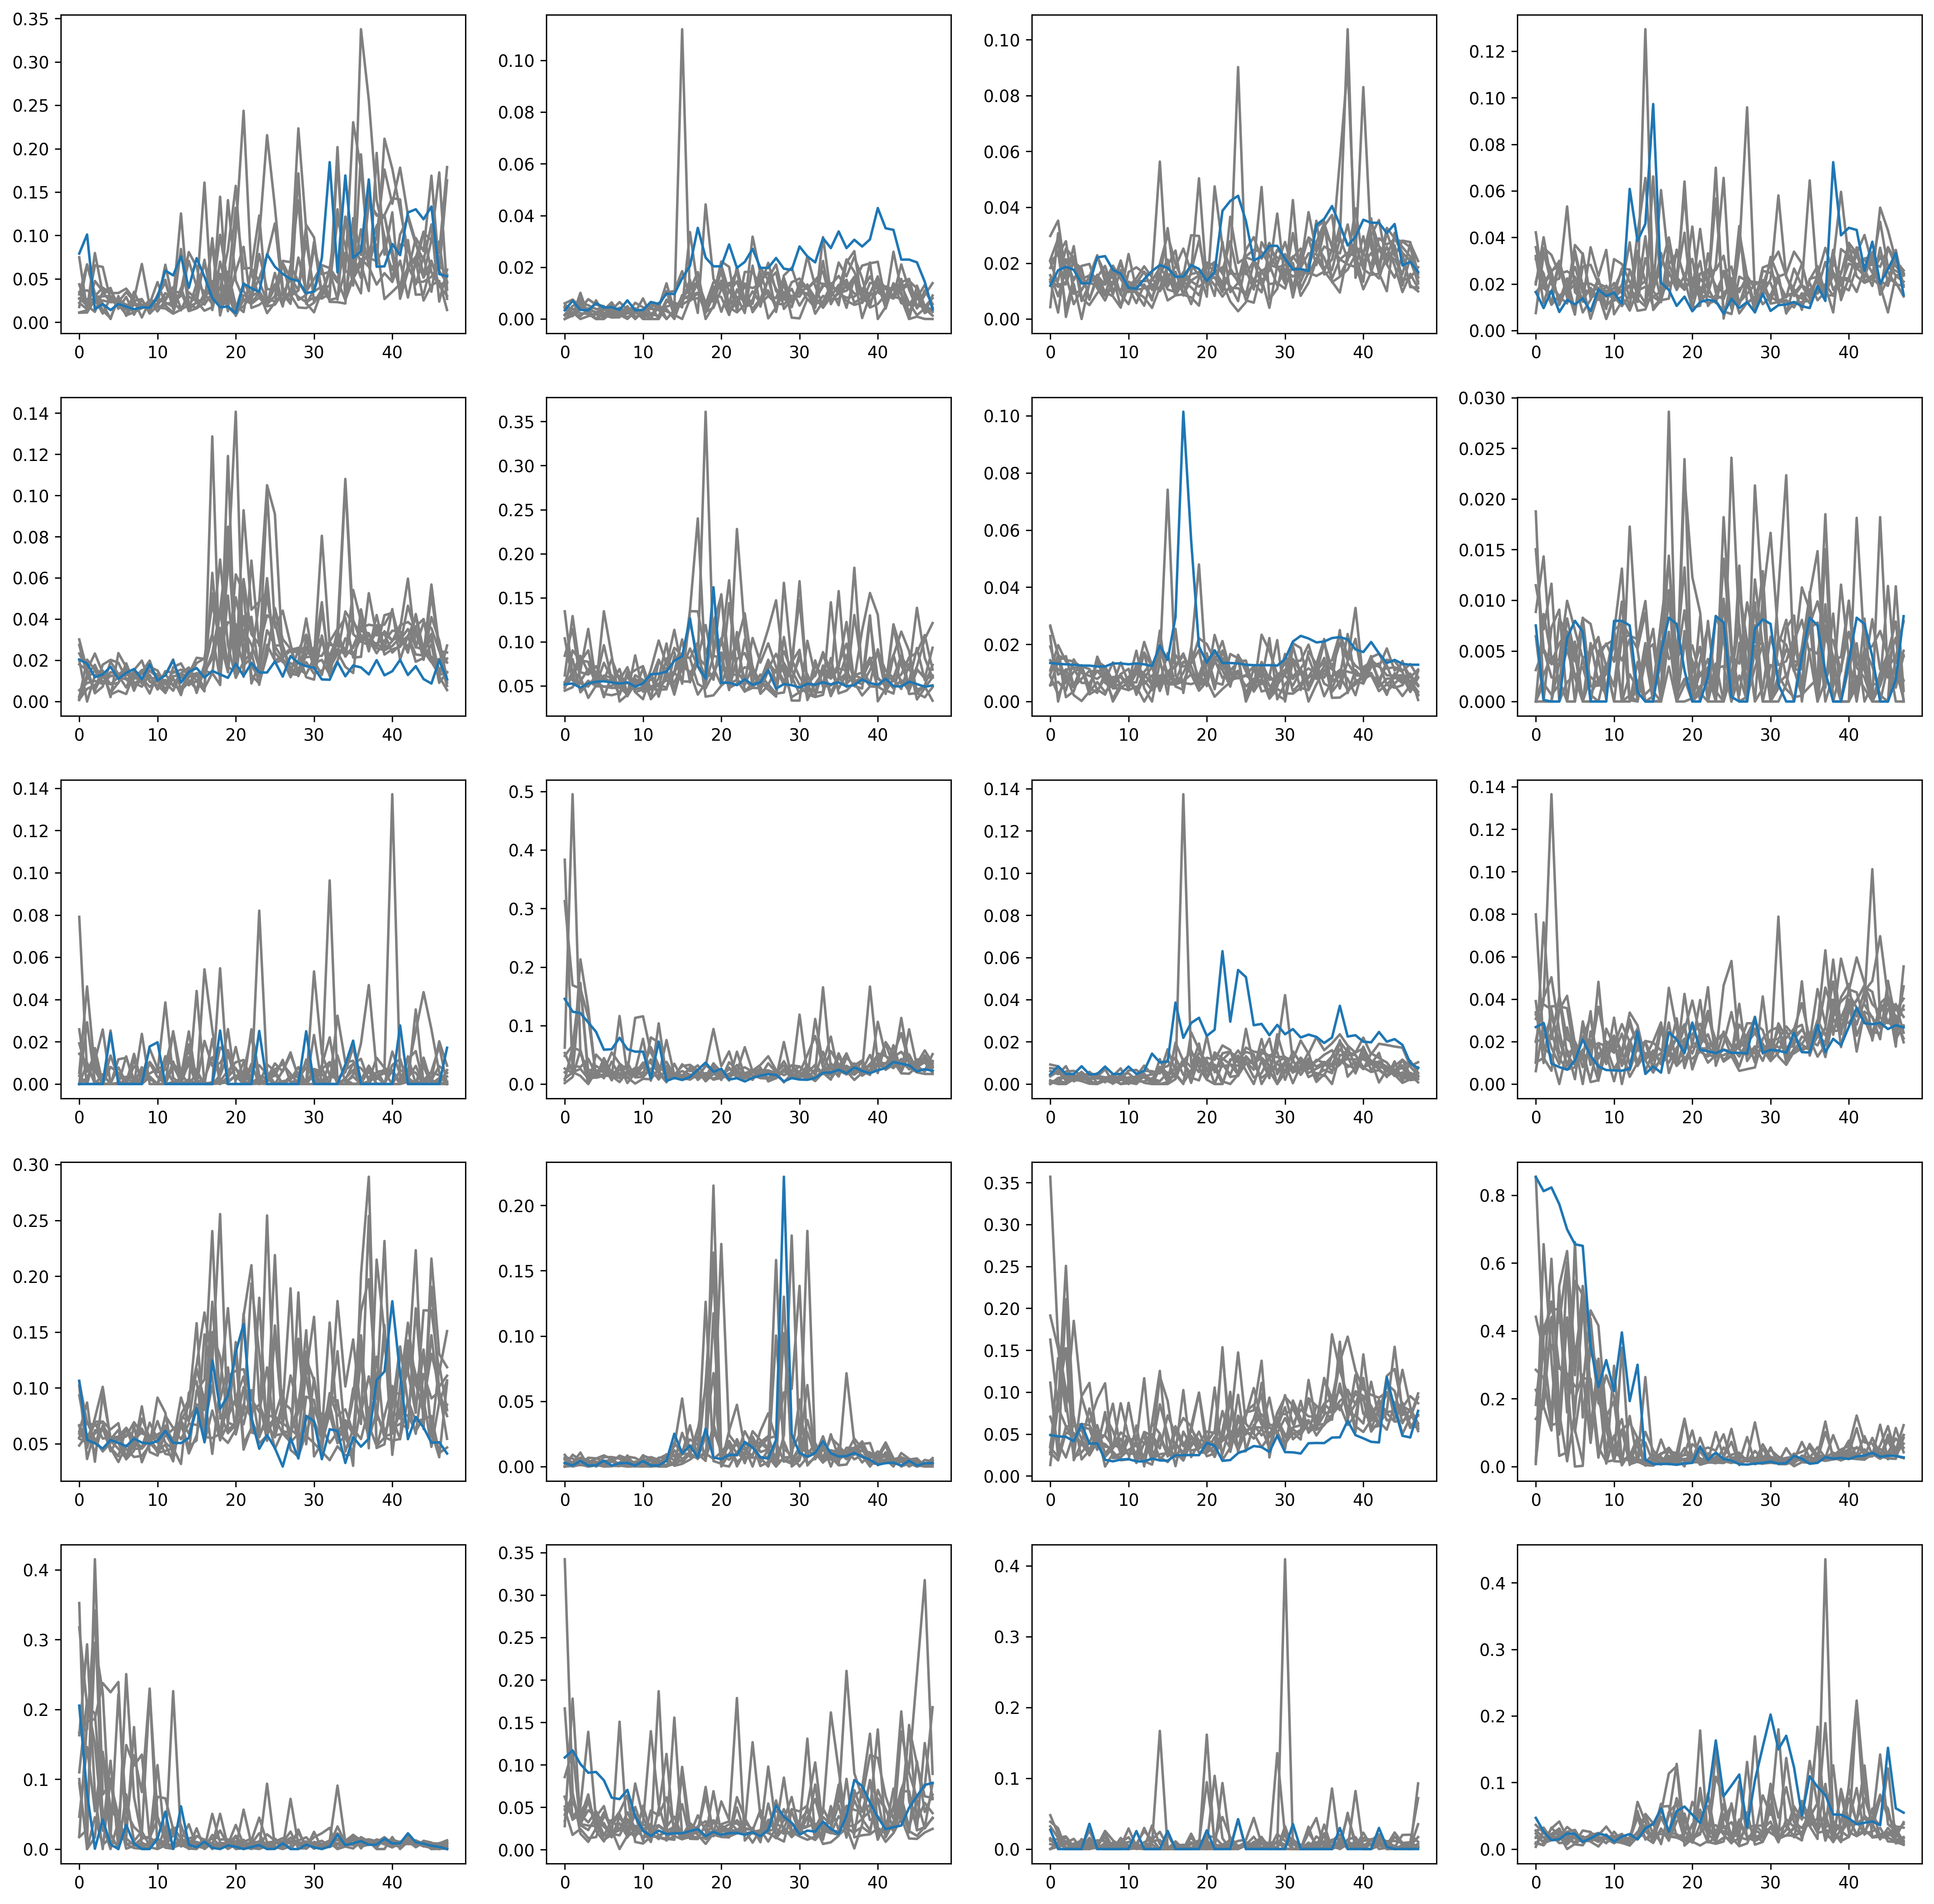

In [10]:
# n = 20
# plt.figure(figsize=(20,20), dpi=300)
# for j in range(n):
#     plt.subplot(int(n/4), 4, j+1)
#     j = j + 200
#     for i in range(10):
#         plt.plot(X_test_hat[j][i], color='gray')
#     plt.plot(X_test[j])